In [1]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf

import prepare_data
import training
import utils
import models
import gin

gin.parse_config_file('config/training.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

frames_threshold = sample_rate * 4 / frame_step

Metal device set to: Apple M1 Pro


2022-05-12 01:14:43.399318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 01:14:43.399443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
train_dataset, _ = prepare_data.datasets(batch_size=1, prefetch=False, take_batches=None, frames_threshold=None)

frame_lengths = []
transcription_lengths = []

for spectrograms, _mel_spectrograms, transcription in iter(train_dataset):
    frame_lengths.append(tf.shape(spectrograms)[1].numpy())
    transcription_lengths.append(tf.shape(transcription)[1].numpy())
    
df = pd.DataFrame({'frames': frame_lengths, 'chars': transcription_lengths})

In [9]:
df['secs'] = df.frames / (sample_rate * 1.0 / frame_step)

In [10]:
df.head()

,frames,chars,secs
0,3323,151,13.292
1,651,30,2.604
2,3327,155,13.308
3,1767,89,7.068
4,2791,143,11.164


<AxesSubplot:>

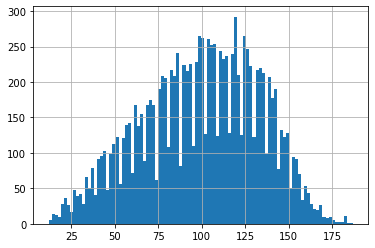

In [11]:
df.chars.hist(bins=100)

<AxesSubplot:>

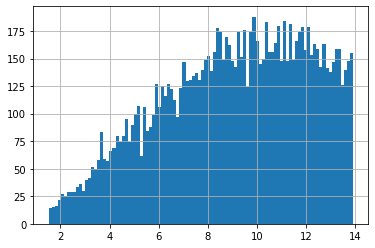

In [12]:
df.secs.hist(bins=100)

<AxesSubplot:>

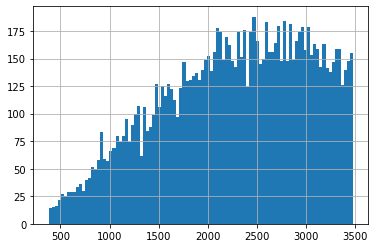

In [16]:
df.frames.hist(bins=100)

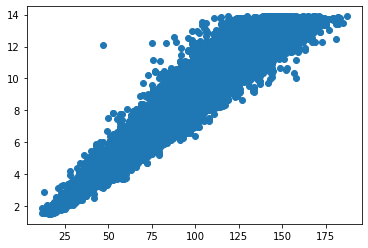

In [13]:
plt.scatter(df.chars, df.secs)

In [14]:
# We might want to start training on small samples first

df[df.secs <= 5].chars.describe()

count    1388.000000
mean       42.027378
std        11.932789
min        12.000000
25%        34.000000
50%        43.000000
75%        51.000000
max        72.000000
Name: chars, dtype: float64

In [15]:
# Probably we would still like a threshold on the time (number of samples)
# To avoid too large batches in the case of outliers

df[df.chars <= 60].secs.describe()

count    1739.000000
mean        4.151216
std         1.177858
min         1.516000
25%         3.372000
50%         4.220000
75%         4.972000
max        12.108000
Name: secs, dtype: float64